In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from scipy import misc

## Load data

In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(len(x_train),-1)
x_test = x_test.reshape(len(x_test),-1)

# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 784)
Number of images in x_train 60000
Number of images in x_test 10000


## Build Classifier

In [4]:
# TODO
# One thing that will play a huge role in this is changing the depth.. smaller depth equates to higher chance of 
# two images falling into the same node

In [5]:
RF = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
RF.fit(x_train[:500], y_train[:500])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [6]:
count = 0.0
#sum(RF.predict(x_train[:500]) == y_train[:500])/500.0
sum(RF.predict(x_test) == y_test)/len(y_test)

0.77390000000000003

In [7]:
# Rows = Image index
# Columns = tree index
# final_nodes[i, j] = the leaf node that input i landed at for tree j
final_nodes = RF.apply(x_train[:500])
final_nodes

array([[ 5, 27, 36, ..., 57, 28, 23],
       [ 9, 56, 55, ..., 25, 11, 36],
       [ 5, 41, 36, ...,  5, 34, 16],
       ..., 
       [ 8, 31,  5, ...,  8, 22, 46],
       [28, 27, 36, ..., 12, 49, 15],
       [23, 50, 47, ..., 49, 13, 44]])

In [8]:
%%time
# TODO Optimize l8r
num_data = 500

num_trees = final_nodes.shape[1]
P = np.zeros((num_data,num_data))

# For each tree
for j in range(100):
    tmp_P = []
    for i in range(num_data):        
        s = np.array([int(final_nodes[i][j] == leaf) for leaf in final_nodes[:, j]])
        tmp_P.append(s)
    P += np.array(tmp_P)

CPU times: user 28.8 s, sys: 306 ms, total: 29.1 s
Wall time: 31.8 s


In [9]:
row_sum = np.sum(P, axis=1)
P_normed = P / row_sum

In [10]:
P

array([[ 100.,    2.,   10., ...,    3.,   12.,    4.],
       [   2.,  100.,    0., ...,    1.,    2.,    0.],
       [  10.,    0.,  100., ...,    5.,    8.,    0.],
       ..., 
       [   3.,    1.,    5., ...,  100.,    4.,   11.],
       [  12.,    2.,    8., ...,    4.,  100.,    4.],
       [   4.,    0.,    0., ...,   11.,    4.,  100.]])

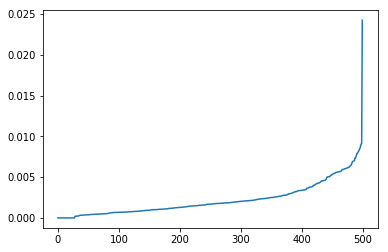

In [11]:
plt.ylim=1
plt.plot(np.arange(500), sorted(P_normed[0,:]))
plt.show()

In [12]:
'''
this diffusion map function takes a Kernel matrix and output the Distance matrix
input: - K: Kernel Matrix (n x n)
       - m: Number of dimensions to reduce to
output: - D: Distance Matrix (n x n)
'''
import time
def diffusion(K, m):
  
  assert K.shape[0] == K.shape[1] # testing that K is a n x n square matrix
  
  # normalized P
  P = K / np.sum(K, axis=1)
  
  # compute the eigenvalues and eigenvectors
  # this can be very expensive...
  eig_time = time.time()
  eig_vals, eig_vecs = np.linalg.eig(P)
  print('time to compute eigenvalues / eigenvectors took {} secs'.format(time.time() - eig_time))
  # sorting the eigenvectors according to its dimensions
  idx = np.argsort(eig_vals)[::-1]
  eig_vals, eig_vecs = np.matrix(eig_vals[idx]), np.matrix(eig_vecs[:, idx])
  assert eig_vals[0, 0] >= eig_vals[0, 1]
  print("shape of eigenvectors: {}".format(eig_vecs.shape))

  # build feature projected matrix Y' (n x m)
  Y_prime = np.zeros((0, K.shape[1]))
  Y_prime_time = time.time()
  for i in range(m):
    Y_prime = np.vstack((Y_prime, np.multiply(eig_vals.T, eig_vecs[:, i].T)))
  print('time to compute Y prime matrix took {} secs'.format(time.time() - Y_prime_time))
  
  # compute the distance matrix using Y' matrix
  D = np.zeros(P.shape)
  D_time = time.time()
  for i in range(K.shape[0]):
    for j in range(i, K.shape[1]):
      # probably have a better numpy function that does this two for-loop
      # this method needs significant improvement
      D[i, j] = D[j, i] = np.linalg.norm(Y_prime[i, :] - Y_prime[j, :]) ** 2
  print('time to compute D matrix took {} secs'.format(time.time() - D_time))
  return D

In [13]:
dist_matrx = diffusion(P, 15)

time to compute eigenvalues / eigenvectors took 0.2833271026611328 secs
shape of eigenvectors: (500, 500)
time to compute Y prime matrix took 0.16899490356445312 secs
time to compute D matrix took 3.507473945617676 secs


In [14]:
dist_matrx

array([[  0.00000000e+00,   5.39973148e-02,   8.49859502e-02, ...,
          9.99458863e-01,   9.99498940e-01,   9.99658408e-01],
       [  5.39973148e-02,   0.00000000e+00,   3.49875509e-03, ...,
          5.88835494e-01,   5.88866256e-01,   5.88988661e-01],
       [  8.49859502e-02,   3.49875509e-03,   0.00000000e+00, ...,
          5.01555591e-01,   5.01583982e-01,   5.01696952e-01],
       ..., 
       [  9.99458863e-01,   5.88835494e-01,   5.01555591e-01, ...,
          0.00000000e+00,   4.01757795e-10,   9.95902792e-09],
       [  9.99498940e-01,   5.88866256e-01,   5.01583982e-01, ...,
          4.01757795e-10,   0.00000000e+00,   6.36022720e-09],
       [  9.99658408e-01,   5.88988661e-01,   5.01696952e-01, ...,
          9.95902792e-09,   6.36022720e-09,   0.00000000e+00]])